# Image Captioning Embedding Extraction 

Co-authored-by: Leila Abdelrahman , Tom Jin and the TensorFlow Team



This code reads in extracted frames and captions them. It saves a checkpoint of the model for future use.

TODO: Train on the remaining 50k images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# # Download image files
# image_folder = '/train2014/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2014.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2014.zip',
#                                       extract = True)
#   PATH = os.path.dirname(image_zip) + image_folder
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder

252878848/252872794 [==============================] - 3s 0us/step


# Image Captioning Portion Pre-Training

Pretraining with the MS COCO Class. This code is heavily based on the TensorFlow Tutorial found here: https://www.tensorflow.org/tutorials/text/image_captioning


Limit the pre-training set to 30,000 images. This is due to low disk space.

In [ ]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    # full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    # all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions= shuffle(all_captions,  random_state=1)

# Select the first 30000 captions from the shuffled set
# num_examples = 30000
# train_captions = train_captions[0:30000]

In [ ]:
len(train_captions), len(all_captions)

(414113, 414113)

## Preprocess the Images 

This is done so the images are all the same dimensions for input through Inception.

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Load the Inception Model

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


## Format the caption tokens


In [ ]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')


In [ ]:
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
# img_name_train, cap_train = img_name_vector, cap_vector
cap_train = cap_vector

In [ ]:
len(cap_train)

414113

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512

# Choose the top 5000 words from the vocabulary
top_k = 5000
vocab_size = top_k + 1
#num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

## Checkpoint

Note: If loading this model from checkpoint, make sure to run all cells above

In [ ]:
# !wget 'https://storage.googleapis.com/cs231n-emotiw/models/image-caption-checkpoint-all.zip'
# !unzip 'image-caption-checkpoint-all.zip'

!rm -rf home/
!wget 'https://storage.googleapis.com/cs231n-emotiw/models/checkpoint-all-4.zip'
!unzip 'checkpoint-all-4.zip'

--2020-06-17 13:10:02--  https://storage.googleapis.com/cs231n-emotiw/models/checkpoint-all-4.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337511082 (322M) [application/zip]
Saving to: ‘checkpoint-all-4.zip’

checkpoint-all-4.zi 100%[===================>] 321.88M  26.9MB/s    in 12s     

2020-06-17 13:10:14 (27.9 MB/s) - ‘checkpoint-all-4.zip’ saved [337511082/337511082]

Archive:  checkpoint-all-4.zip
   creating: home/jupyter/train/
  inflating: home/jupyter/train/ckpt-7.data-00001-of-00002  
  inflating: home/jupyter/train/ckpt-3.data-00001-of-00002  
  inflating: home/jupyter/train/ckpt-6.index  
  inflating: home/jupyter/train/ckpt-3.index  
  inflating: home/jupyter/train/ckpt-4.data-00001-of-00002  
  inflating: home/jupyter/train/ckpt-5.index  
  inflating: home/jupyte

In [ ]:
checkpoint_path = "/content/home/jupyter/train/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0

if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Get the Data 

In [ ]:
!cp '/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw/train_frames.tar.gz' .
#!cp '/content/drive/My Drive/cs231n-project/datasets/emotiw/train_frames.tar.gz' .

In [ ]:
!tar -xzf train_frames.tar.gz

In [ ]:
!cp '/content/drive/My Drive/Machine-Learning-Projects/cs231n-project/datasets/emotiw/val_frames.tar.gz' .
#!cp '/content/drive/My Drive/cs231n-project/datasets/emotiw/val_frames.tar.gz' .

!tar -xzf val_frames.tar.gz

In [ ]:
!ls train_frames/1 | head

frame_101_10.mp4_0.jpg
frame_101_10.mp4_10.jpg
frame_101_10.mp4_11.jpg
frame_101_10.mp4_12.jpg
frame_101_10.mp4_13.jpg
frame_101_10.mp4_14.jpg
frame_101_10.mp4_1.jpg
frame_101_10.mp4_2.jpg
frame_101_10.mp4_3.jpg
frame_101_10.mp4_4.jpg


In [ ]:
!nvidia-smi

Wed Jun 17 01:58:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    33W / 250W |    481MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def evaluate(image, max_length=16):
    def load_image(image_path):
      img = tf.io.read_file(image_path)
      img = tf.image.decode_jpeg(img, channels=3)
      img = tf.image.resize(img, (299, 299))
      img = tf.keras.applications.inception_v3.preprocess_input(img)
      return img, image_path
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: a happy while <unk> in a hallway of kids <end>


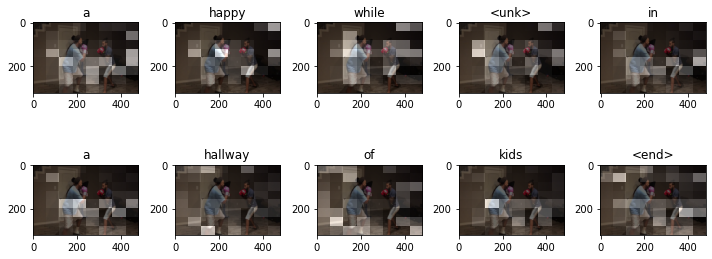

In [ ]:
# captions on the validation set
import numpy as np
import cv2
import matplotlib.pyplot as plt

result, attention_plot = evaluate("train_frames/1/frame_101_10.mp4_0.jpg")

print ('Prediction Caption:', ' '.join(result))
plot_attention("train_frames/1/frame_101_10.mp4_0.jpg", result, attention_plot)



Prediction Caption: a little boy and a child have kites at a skateboard <end>


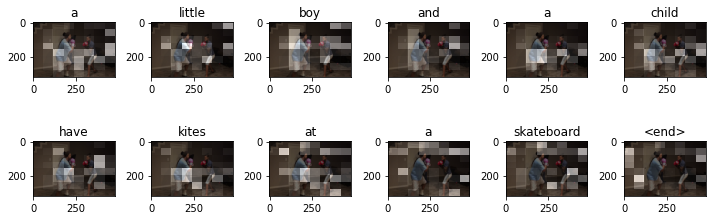

In [ ]:
# captions on the validation set
import numpy as np
import cv2
import matplotlib.pyplot as plt

result, attention_plot = evaluate("train_frames/1/frame_101_10.mp4_0.jpg")

print ('Prediction Caption:', ' '.join(result))
plot_attention("train_frames/1/frame_101_10.mp4_0.jpg", result, attention_plot)


In [ ]:
import numpy as np
import random
import cv2
from os import listdir
from os.path import isfile, join
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
class DataGenerator(tf.keras.utils.Sequence):
    """
    Generates data based on a directory of frames
    """
    def __init__(self, dir, batch_size=32, frames_to_use=-1, shuffle=True , return_words=False , return_images=True , max_workers=32):
        self.frames_to_use = frames_to_use
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle = shuffle
        self.classes = self.find_classes()
        self.video_names, self.video_map, self.video_to_class, self.num_samples, self.min_frames = self.find_samples()
        self.on_epoch_end()
        self.return_words = return_words
        self.return_images = return_images
        self.max_workers = max_workers
        print(f"Found {self.num_samples} frames belonging to {len(self.video_names)} videos belonging to {len(self.classes)} classes.")
        print(f"Min frames determined to be {self.min_frames}")

    def find_classes(self):
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        return sorted(list(set(category_folders)))

    def find_samples(self):
        """
        Returns the following video frame structure:

        {
            "vid1": [
                "frame1.jpg",
                "frame2.jpg",
                ...
            ]
        }

        """
        num_samples = 0
        min_frames = -1
        video_map = {}
        vid_to_cat = {}
        category_folders = [f for f in listdir(self.dir) if not isfile(join(self.dir, f))]
        for category_folder in category_folders:
            cat_path = join(self.dir, category_folder)
            frames = [f for f in listdir(cat_path) if isfile(join(cat_path, f))]
            for frame in frames:
                # frame = frame_101_7.mp4_8.jpg
                frame_arr = frame.split(".mp4_")
                vid_name = frame_arr[0]
                if vid_name not in video_map:
                    video_map[vid_name] = []
                    vid_to_cat[vid_name] = category_folder
                video_map[vid_name].append(frame)
            
            for k in video_map.keys():
                # make sure the frames for each video are in sorted order
                video_map[k] = sorted(video_map[k], key=lambda x: x.split(".mp4_")[0] + x.split(".mp4_")[1].split(".jpg")[0].zfill(3))
                if min_frames == -1 or len(video_map[k]) < min_frames:
                    min_frames = len(video_map[k])

        return list(video_map.keys()), video_map, vid_to_cat, len(vid_to_cat), min_frames

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return self.num_samples

    def get(self, index):
        """
        Generate one batch of data
        """
        return [f"{self.dir}/{self.video_to_class[self.video_names[index]]}/{x}" for x in self.video_map[self.video_names[index]]]





In [ ]:
train_generator = DataGenerator("train_frames", frames_to_use=12, batch_size=BATCH_SIZE)
validation_generator = DataGenerator("val_frames", frames_to_use=12, batch_size=BATCH_SIZE)

Found 2661 frames belonging to 2661 videos belonging to 3 classes.
Min frames determined to be 7
Found 766 frames belonging to 766 videos belonging to 3 classes.
Min frames determined to be 7


In [ ]:
train_generator.get(0)

['train_frames/1/frame_279_3.mp4_0.jpg',
 'train_frames/1/frame_279_3.mp4_1.jpg',
 'train_frames/1/frame_279_3.mp4_2.jpg',
 'train_frames/1/frame_279_3.mp4_3.jpg',
 'train_frames/1/frame_279_3.mp4_4.jpg',
 'train_frames/1/frame_279_3.mp4_5.jpg',
 'train_frames/1/frame_279_3.mp4_6.jpg',
 'train_frames/1/frame_279_3.mp4_7.jpg',
 'train_frames/1/frame_279_3.mp4_8.jpg',
 'train_frames/1/frame_279_3.mp4_9.jpg',
 'train_frames/1/frame_279_3.mp4_10.jpg',
 'train_frames/1/frame_279_3.mp4_11.jpg',
 'train_frames/1/frame_279_3.mp4_12.jpg',
 'train_frames/1/frame_279_3.mp4_13.jpg',
 'train_frames/1/frame_279_3.mp4_14.jpg']

train_frames/1/frame_279_3.mp4_0.jpg
a man sitting at a table eating food on the desk <end>


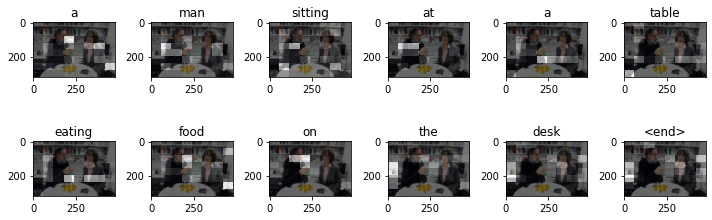

train_frames/1/frame_286_20.mp4_0.jpg
a man and crown gathered in a restaurant in the middle finger in chairs <end>


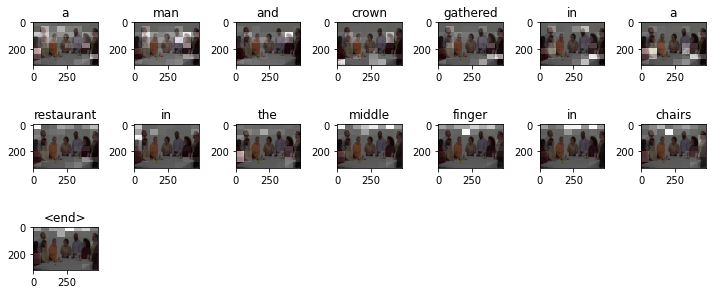

train_frames/1/frame_279_1.mp4_0.jpg
a man standing at a black table with a striped tie <end>


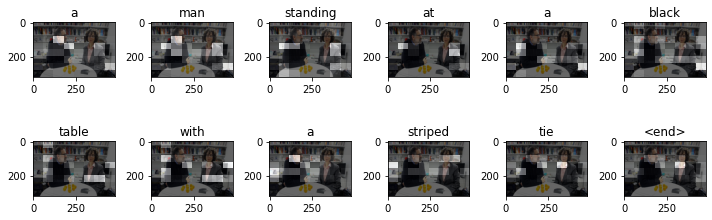

train_frames/1/frame_290_1.mp4_0.jpg
a group of tennis players in dress shirts with ties are standing next to each other


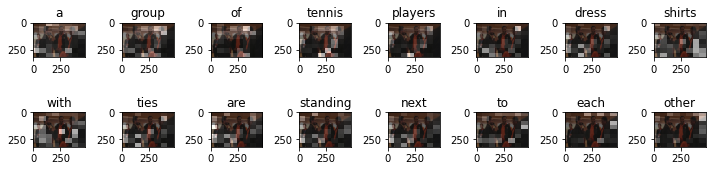

train_frames/1/frame_101_15.mp4_0.jpg
a little girl are making a woman watches <end>


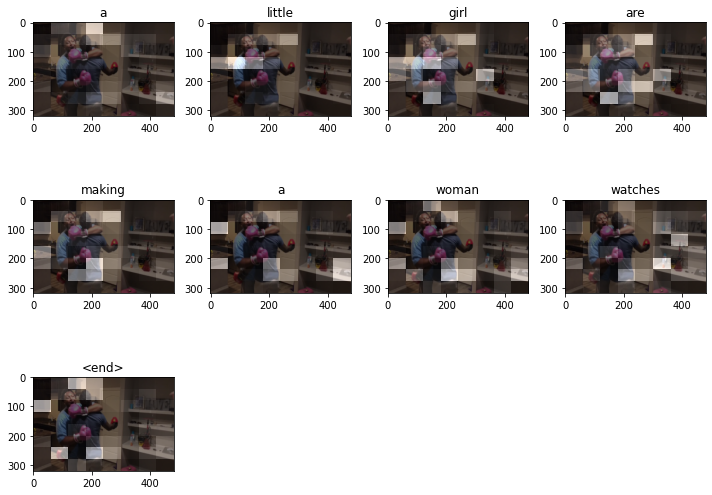

train_frames/1/frame_25_1.mp4_0.jpg
a group of people are standing around at a table <end>


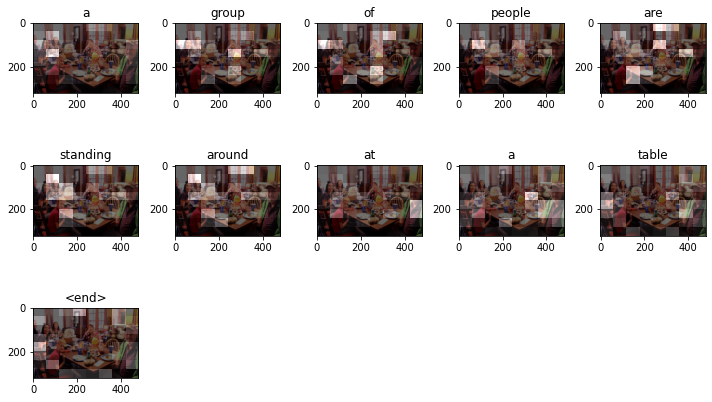

train_frames/1/frame_215_3.mp4_0.jpg
high five snowboard show luggage that makes its <unk> down <end>


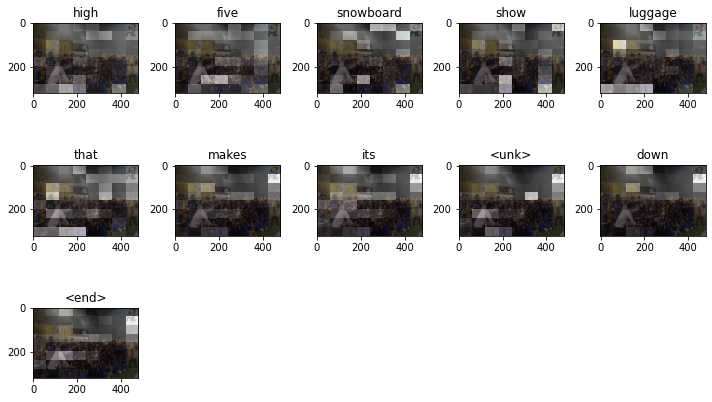

In [ ]:

for i in range(len(train_generator)):
    result, attention_plot = evaluate(train_generator.get(i)[0])
    print(train_generator.get(i)[0])
    print(" ".join(result))

    plot_attention(train_generator.get(i)[0], result, attention_plot)

    if i > 5:
        break


### Pre-process 

Extract the captions and underlying embeddings from each video

In [ ]:
from tqdm import tqdm
train_captions = []
train_categories = []
train_videos = []

for i in tqdm(range(len(train_generator))):
    train_category = train_generator.get(i)[0].split("/")[1]
    train_categories.append(train_category)
    frame_captions = []
    for frame in train_generator.get(i):
        result, _ = evaluate(frame)
        # print(train_generator.get(i)[0])
        # print(" ".join(result))
        frame_captions.append(result)

    train_captions.append(frame_captions)
    train_videos.append(train_generator.get(i)[0].split(".mp4")[0].split("frame_")[1])

    # plot_attention(train_generator.get(i)[0], result, attention_plot)

    # if i > 5:
    #     break


100%|██████████| 2661/2661 [2:55:38<00:00,  3.96s/it]


In [ ]:
import pickle

train_caption_obj = {
    "train_captions": train_captions,
    "train_categories": train_categories,
    "train_videos": train_videos
}

with open("train_captions_v3.pkl", "wb") as f:
    pickle.dump(train_caption_obj, f)

In [ ]:
!cp train_captions_v3.pkl drive/'My Drive/Machine-Learning-Projects'/cs231n-project/
# !cp train_captions.pkl drive/'My Drive'/cs231n-project/

In [ ]:
from tqdm import tqdm
val_captions = []
val_categories = []
val_videos = []

for i in tqdm(range(len(validation_generator))):
    val_category = validation_generator.get(i)[0].split("/")[1]
    val_categories.append(val_category)
    frame_captions = []
    for frame in validation_generator.get(i):
        result, _ = evaluate(frame)
        frame_captions.append(result)

    val_captions.append(frame_captions)
    val_videos.append(validation_generator.get(i)[0].split(".mp4")[0].split("frame_")[1])



100%|██████████| 766/766 [48:09<00:00,  3.77s/it]


In [ ]:
import pickle

val_caption_obj = {
    "val_captions": val_captions,
    "val_categories": val_categories,
    "val_videos": val_videos
}

with open("val_captions_v3.pkl", "wb") as f:
    pickle.dump(val_caption_obj, f)

In [ ]:
# !cp val_captions.pkl drive/'My Drive'/cs231n-project/
!cp val_captions_v3.pkl drive/'My Drive/Machine-Learning-Projects'/cs231n-project/